Welcome to the movie recommendation system. Please run the following cell to begin.

In [9]:
#Importing all the needed libraries
from sklearn.metrics import mean_squared_error
import ast
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#Getting user input
user_input = input("Enter the title of a movie you enjoyed: ")

#Data manipulation
#Reading in the csv files
movies_df = pd.read_csv('movies.csv')
credits_df = pd.read_csv('credits.csv')

#Merge the csv files into one dataframe
ratings = movies_df.merge(credits_df, on='title', how='left')

#Make the titles lowercase to prevent case-sensitive errors
ratings['title'] = ratings['title'].str.lower()

#Drop unnecessary columns
ratings = ratings[['movie_id', 'title', 'overview', 'genres', 'keywords', 'cast', 'crew']]

ratings.dropna(inplace=True)

#Simplifying the dataframe
def data_processor_1(obj):
    temp_ratings = []
    for row in ast.literal_eval(obj):
        temp_ratings.append(row['name'])
    return temp_ratings

ratings['genres'] = ratings['genres'].apply(data_processor_1)
ratings['keywords'] = ratings['keywords'].apply(data_processor_1)

def data_processor_2(obj):
    temp_ratings = []
    counter = 0
    for row in ast.literal_eval(obj):
        if counter != 3:
            temp_ratings.append(row['name'])
            counter += 1
        else:
            break
    return temp_ratings

ratings['cast'] = ratings['cast'].apply(data_processor_2)

def data_processor_3(obj):
    temp_ratings = []
    for row in ast.literal_eval(obj):
        if row['job'] == 'Director':
            temp_ratings.append(row['name'])
    return temp_ratings

ratings['crew'] = ratings['crew'].apply(data_processor_3)

#Seperating each word
ratings['overview'] = ratings['overview'].apply(lambda x: x.split())
ratings['genres'] = ratings['genres'].apply(lambda x: [i.replace(" ", "") for i in x])
ratings['keywords'] = ratings['keywords'].apply(lambda x: [i.replace(" ", "") for i in x])
ratings['cast'] = ratings['cast'].apply(lambda x: [i.replace(" ", "") for i in x])
ratings['crew'] = ratings['crew'].apply(lambda x: [i.replace(" ", "") for i in x])

ratings['tags'] = ratings['overview'] + ratings['genres'] + ratings['keywords'] + ratings['cast'] + ratings['crew']

ratings['tags'] = ratings['tags'].apply(lambda x:' '.join(x))
ratings['tags'] = ratings['tags'].apply(lambda X:X.lower())

#Creating another dataframe with less columns
simple_ratings = ratings[['movie_id', 'title', 'tags']]

#Creating the main machine learning model
model = NearestNeighbors(metric='cosine', algorithm='auto')

#Creating the TFIDF matrix
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(simple_ratings['tags'].fillna(''))

#Creating the TSVD matrix
svd = TruncatedSVD(n_components=100)
svd_matrix = svd.fit_transform(tfidf_matrix)

#Loading the matrix
model.fit(svd_matrix)

#Main machine learning function
def movie_recommend(movie_title, ratings, model, top_n=5):
    movie_index = ratings[ratings['title'] == movie_title].index
    
    if not movie_index.empty:
        movie_index = movie_index[0]
        input_vector = svd_matrix[movie_index].reshape(1, -1)
        distances, indices = model.kneighbors(input_vector, n_neighbors=top_n+1)
        recommendations = ratings.iloc[indices.flatten()[1:]]['title'].tolist()
        return recommendations
    else:
        return []
    

#Printing the results    
user_input_value = user_input.lower()
if user_input_value not in ratings['title'].str.lower().values:
    print("Sorry, that movie was not found in our database.")
    
else:
    movies_recommended = movie_recommend(user_input_value, simple_ratings, model)
    print(f"Movie recommendations based off {user_input_value}.")
    i = 1
    for movie in movies_recommended:
        print(f"{i}. {movie}")
        i += 1     

Movie recommendations based off up.
1. ice age: dawn of the dinosaurs
2. inside out
3. raising helen
4. the nut job
5. despicable me


After receiving your personalized results, please manually click the next cell, then run it and all remaining cells.

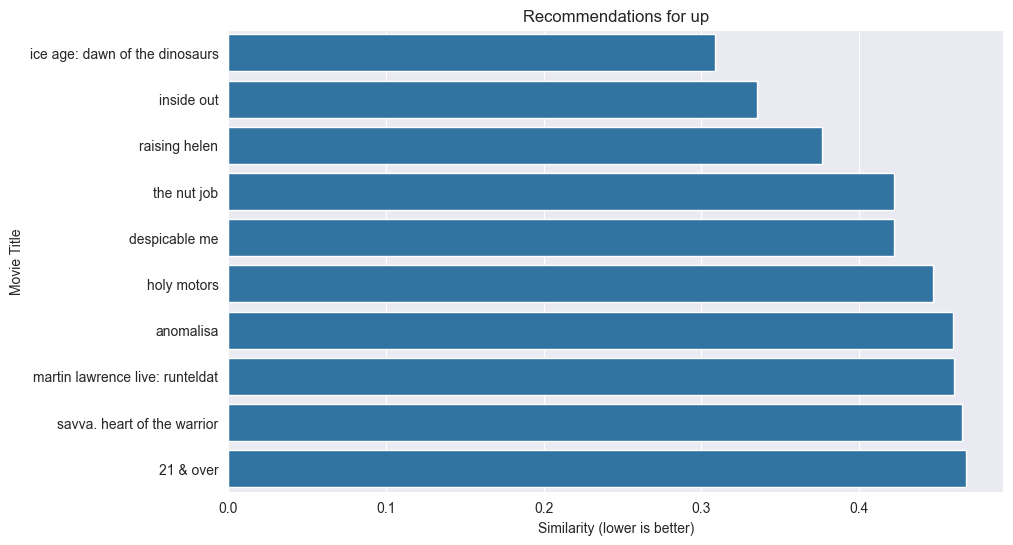

In [10]:
#Creating a chart visualizing movie recommendations
movie_index = ratings[ratings['title'] == user_input].index
    
if not movie_index.empty:
    movie_index = movie_index[0]
    input_vector = svd_matrix[movie_index].reshape(1, -1)
    distances, indices = model.kneighbors(input_vector, n_neighbors=11)
    recommended_titles = ratings.iloc[indices.flatten()[1:]]['title'].tolist()
    distances = distances.flatten()[1:]
        
    df_recommendations = pd.DataFrame({
        'Movie': recommended_titles,
        'Distance': distances
    })
       
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Distance', y='Movie', data=df_recommendations, legend=False)
    plt.ylabel('Movie Title')
    plt.xlabel('Similarity (lower is better)')
    plt.title(f'Recommendations for {user_input}')
    plt.show()
else:
    print("Sorry, that movie was not found in our database.")

In [11]:
# TF-IDF Validation
print("TFIDF Scores:")
s_titles = tfidf.get_feature_names_out()
s_scores = tfidf_matrix.toarray().flatten()
word_scores = [(word, s_scores) for word, s_scores in zip(s_titles, s_scores)]
word_scores.sort(key=lambda x: x[1], reverse=True)
for word, s_scores in word_scores[:50]:
    print(f"{word}: {s_scores: .3f}")
        
print()

TFIDF Scores:
marine:  0.294
alien:  0.221
antiwar:  0.193
spacewar:  0.193
loveaffair:  0.186
powerrelations:  0.186
22nd:  0.181
cgi:  0.177
mindandsoul:  0.177
paraplegic:  0.177
pandora:  0.173
samworthington:  0.173
spacecolony:  0.173
alienplanet:  0.170
jamescameron:  0.170
dispatched:  0.165
civilization:  0.161
zoesaldana:  0.159
protecting:  0.158
tribe:  0.158
cultureclash:  0.156
orders:  0.150
sigourneyweaver:  0.150
futuristic:  0.147
moon:  0.146
spacetravel:  0.146
unique:  0.143
torn:  0.142
following:  0.128
society:  0.126
soldier:  0.121
space:  0.121
century:  0.118
3d:  0.112
future:  0.106
mission:  0.103
battle:  0.103
fantasy:  0.078
sciencefiction:  0.073
adventure:  0.063
romance:  0.061
action:  0.055
00:  0.000
000:  0.000
007:  0.000
07am:  0.000
10:  0.000
100:  0.000
1000:  0.000
101:  0.000



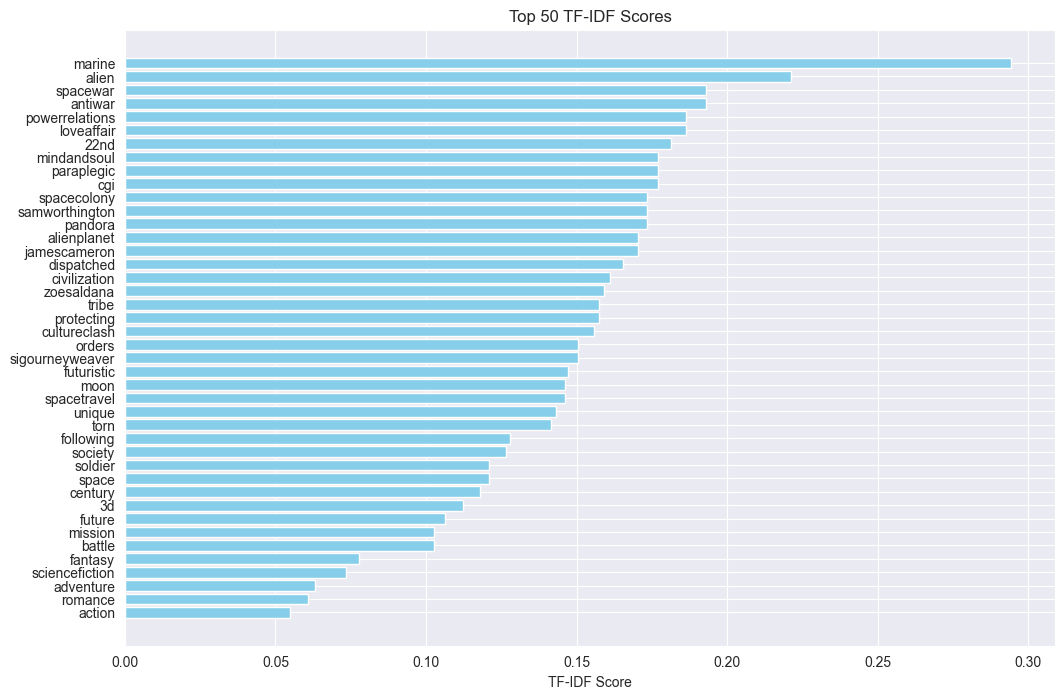

In [12]:
#Creating a graph to visualize TFIDF validation
tf_index = 0
tf_scores = tfidf_matrix[tf_index].toarray().flatten()
tf_titles = tfidf.get_feature_names_out()

non_zero = tf_scores > 0
filtered_scores = tf_scores[non_zero]
filtered_features = np.array(tf_titles)[non_zero]

sorted_indices = np.argsort(filtered_scores)[::-1]
sorted_scores = filtered_scores[sorted_indices]
sorted_features = filtered_features[sorted_indices]

plt.figure(figsize=(12, 8))
plt.barh(sorted_features[:50], sorted_scores[:50], color='skyblue')
plt.xlabel('TF-IDF Score')
plt.title(f'Top 50 TF-IDF Scores')
plt.gca().invert_yaxis()
plt.show()

In [13]:
# Truncated SVD Validation
reconstructed_matrix = svd.inverse_transform(svd_matrix)
reconstruction_error = mean_squared_error(tfidf_matrix.toarray(),reconstructed_matrix)
decimal_number = reconstruction_error
print(f"Truncated SVD reconstruction error: {decimal_number:.10f}")

Truncated SVD reconstruction error: 0.0000254641


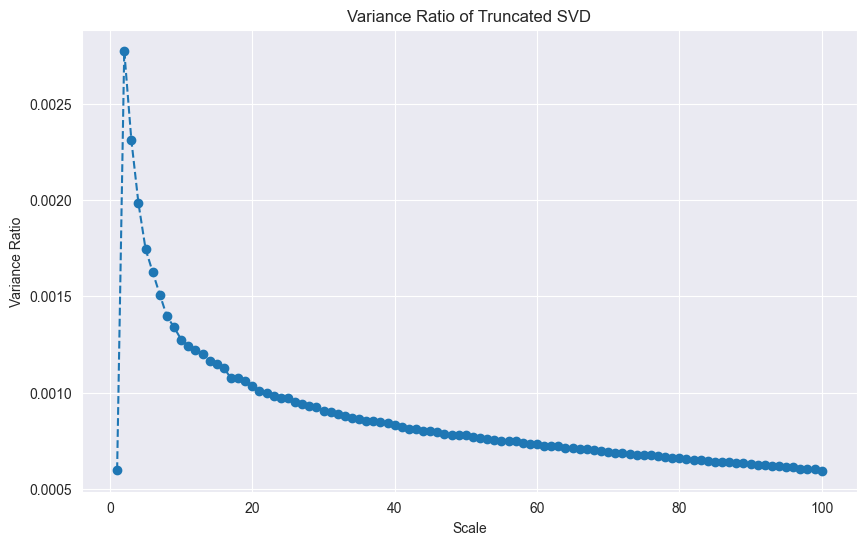

In [14]:
#Creating a graph to visualize tsvd variance
tsvd_variance = svd.explained_variance_ratio_

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(tsvd_variance) + 1), tsvd_variance, marker='o', linestyle='--')
plt.xlabel('Scale')
plt.ylabel('Variance Ratio')
plt.title('Variance Ratio of Truncated SVD')
plt.grid(True)
plt.show()